### Problem 4

For your next vacation, you decided to spend a week with five of your friends from school. It is a very convenient house with many things to do nearby. But the most important benefit is that everybody has commited to be happy when they are in the house. So anyone wanting to enter the house must prove their current state of happiness.
As a deep learning expert, to make sure the "Happy" rule is strictly applied, you are going to build an algorithm which that uses pictures from the front door camera to check if the person is happy or not. The door should open only if the person is happy.
You have gathered pictures of your friends and yourself, taken by the front-door camera. The dataset is labbeled.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle

/Users/GYUNAM/.pyenv/versions/3.4.5/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [2]:
happy_list = cPickle.load(open('./data_files/happy_list.pkl','rb'))
happy_labels = cPickle.load(open('./data_files/happy_labels.pkl','rb'))

unhappy_list = cPickle.load(open('./data_files/unhappy_list.pkl', 'rb'))
unhappy_labels = cPickle.load(open('./data_files/unhappy_labels.pkl','rb'))

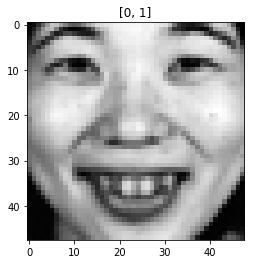

In [3]:
# happy
idx = np.random.randint(len(happy_list))
plt.imshow(happy_list[idx].reshape(48,48),'gray')
plt.title('{}'.format(happy_labels[idx]))
plt.show()

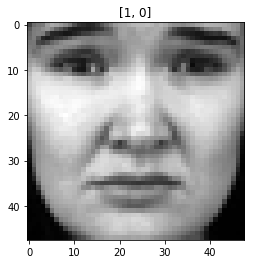

In [4]:
# unhappy
idx = np.random.randint(len(unhappy_list))
plt.imshow(unhappy_list[idx].reshape(48,48),'gray')
plt.title('{}'.format(unhappy_labels[idx]))
plt.show()

In [5]:
train_x_total = cPickle.load(open('./data_files/train_x_total.pkl','rb'))
train_y_total = cPickle.load(open('./data_files/train_y_total.pkl', 'rb'))

In [6]:
test_x_total = cPickle.load(open('./data_files/test_x_total.pkl', 'rb'))
test_y_total = cPickle.load(open('./data_files/test_y_total.pkl', 'rb'))

In [7]:
input_h = 48 # Input height
input_w = 48 # Input width
input_ch = 1 # Input channel : Gray scale

## First convolution layer
# Filter size
k1_h = 3
k1_w = 3
# the number of channels
k1_ch = 32
# Pooling size
p1_h = 2
p1_w = 2
# (None, 14, 14 ,32)

## Second convolution layer
# Filter size
k2_h = 3
k2_w = 3
# the number of channels
k2_ch = 64
# Pooling size
p2_h = 2
p2_w = 2
# (None, 7, 7 ,64)

## Fully connected
# Flatten the features
# -> (None, 7*7*64)
conv_result_size = int((input_h/(p1_h*p2_h)) * (input_w/(p1_w*p2_w)) * k2_ch)
n_hidden1 = 100
n_output = 2

In [8]:

weights = {
    'conv1' : tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch],stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch],stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([conv_result_size, n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_hidden1, n_output], stddev = 0.1))
}

biases = {
    'conv1' : tf.Variable(tf.random_normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_ch], stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev = 0.1))
}

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

In [9]:
# Define Network
def net(x, weights, biases):
    ## First convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], 
                         strides= [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, 
                           ksize = [1, p1_h, p1_w, 1], 
                           strides = [1, p1_h, p1_w, 1], 
                           padding = 'VALID'
                           )
    
    ## Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], 
                         strides= [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, 
                           ksize = [1, p2_h, p2_w, 1], 
                           strides = [1, p2_h, p2_w, 1], 
                           padding = 'VALID')

    # shape = conv2.get_shape().as_list()
    # maxp2_re = tf.reshape(conv2, [-1, shape[1]*shape[2]*shape[3]])
    maxp2_re = tf.reshape(maxp2, [-1, conv_result_size])
    
    ### Fully connected
    hidden1 = tf.add(tf.matmul(maxp2_re, weights['hidden1']), biases['hidden1'])
    hidden1 = tf.nn.relu(hidden1)
    output = tf.add(tf.matmul(hidden1, weights['output']), biases['output'])
    return output

In [10]:
LR = 0.0001

pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
n_batch = 50
n_iter = 2500
n_prt = 250



In [12]:
# Run initialize
# config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
# sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    idx = np.random.randint(len(train_x_total), size= n_batch)
    train_x = [train_x_total[i] for i in idx]
    train_y = [train_y_total[i] for i in idx]
    train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
    train_y = np.reshape(train_y, [-1, n_output])
    sess.run(optm, feed_dict={x: train_x,  y: train_y})

    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x, y: train_y})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 88.24232482910156
Iter : 250
Cost : 1.8438607454299927
Iter : 500
Cost : 0.0180275309830904
Iter : 750
Cost : 0.5475150346755981
Iter : 1000
Cost : 0.7745928764343262
Iter : 1250
Cost : 0.00025699962861835957
Iter : 1500
Cost : 6.934404154890217e-06
Iter : 1750
Cost : 0.04491037502884865
Iter : 2000
Cost : 0.0471925362944603
Iter : 2250
Cost : 1.430511264999268e-08


In [13]:

idx = np.random.randint(len(test_x_total),size=100)
test_x = [test_x_total[i] for i in idx]
test_y = [test_y_total[i] for i in idx]

my_pred = sess.run(pred, feed_dict={x : np.array(test_x).reshape(-1, 48, 48, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(accr*100))

Accuracy : 94.0%


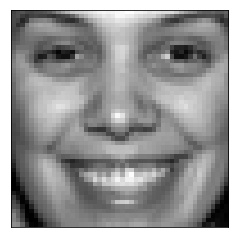

Prediction : 1
Label : 1


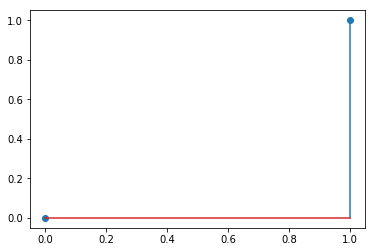

Probability : [0. 1.]


In [16]:

idx = np.random.randint(len(test_x_total),size=1)
test_x = [test_x_total[i] for i in idx]
test_y = [test_y_total[i] for i in idx]
logits = sess.run(tf.nn.softmax(pred), feed_dict={x : np.array(test_x).reshape(-1, 48, 48, 1)})
predict = np.argmax(logits)

plt.imshow(np.array(test_x).reshape(48, 48), 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

print('Prediction : {}'.format(predict))
print('Label : {}'.format(np.argmax(test_y)))

plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision=2, suppress=True)
print('Probability : {}'.format(logits.ravel()))